## Importar librerías y cargar archivos


In [1]:
import pandas as pd
import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sn
import pylab as pl
from statsmodels.graphics.gofplots import qqline
from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm
from statsmodels.graphics.gofplots import qqline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 500
png_renderer.height = 500

pio.renderers.default = "colab"

In [3]:
#cargar los datos
path = './employee_attrition.csv'
df = pd.read_csv(path)

## 0. (TL,DR) Exploración de los datos

### 0.1 Exploración de variables con respecto a la variable objetivo.

In [4]:
df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,1,10,3,3,10,7,1,7


In [5]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [6]:
df.shape

(1470, 33)

In [7]:
# Evaluar variable de interes
renuncias = pd.DataFrame(df['Attrition'].value_counts())
renuncias = renuncias.reset_index()
renuncias

,index,Attrition
0,No,1233
1,Yes,237


In [8]:
fig = px.pie(renuncias, values='Attrition', names='index', title='Porcentaje de renuncias en el dataset')
fig.show()

Del total de trabajadores del dataset, el 16.1% tomó la decisión de renunciar. Esto de ninguna forma demuestra un desbalance o sesgo en los datos pues es lógico que el número de renuncias sea menor al de permanencia.

In [9]:
#Explorar Variables
for variable in df.columns:
  fig = px.histogram(df, variable ,color='Attrition')
  fig.show()

Se puede observar que a priori, las distribuciones para cada variable son similares para ambos grupos.

#### 0.1.1 Orden de variables según el indice de Gini.

Para ordenar las variables que tienen mayor valor con respecto a la variable objetivo, es posible hacer varios arboles de decisión y obtener el orden de preferencia de las variables según el indice de Gini (indice utilizan los árboles de decisión). Lo anterior es fundamentado en la página 19 del siguiente [artículo](https://documentation.sas.com/api/docsets/emgsj/15.1/content/emgsj.pdf?locale=en) .

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

data = df.drop(columns = 'Attrition')
data= data.apply(LabelEncoder().fit_transform)
data = data.astype(float)
target = pd.DataFrame(df['Attrition'].where(df['Attrition'] == 'Yes', 0))
target = target['Attrition'].where(target['Attrition'] == 0, 1)
target = target.astype(int)
cols = []
gini_value = []
gini_name = []

for i in range(len(data.columns)):
  X, y = data, target
  clf = tree.DecisionTreeClassifier(max_depth=1, criterion='gini')
  clf = clf.fit(X, y)
  gini = clf.tree_.impurity[0]
  trgt = clf.tree_.feature
  col_max = X.iloc[:,trgt[trgt>=0]].columns
  cols.append(list(X.iloc[:,trgt[trgt>0]].columns))
  gini_value.append(gini)
  gini_name.append(trgt)
  data = data.drop(columns = col_max)

In [11]:
cols

[['OverTime'],
 ['TotalWorkingYears'],
 ['MonthlyIncome'],
 ['JobLevel'],
 ['YearsAtCompany'],
 ['YearsWithCurrManager'],
 ['StockOptionLevel'],
 [],
 ['MaritalStatus'],
 ['YearsInCurrentRole'],
 ['JobRole'],
 ['EnvironmentSatisfaction'],
 ['JobInvolvement'],
 ['WorkLifeBalance'],
 ['DistanceFromHome'],
 ['JobSatisfaction'],
 ['Department'],
 ['NumCompaniesWorked'],
 [],
 ['MonthlyRate'],
 ['EducationField'],
 [],
 ['EmployeeNumber'],
 ['TrainingTimesLastYear'],
 ['YearsSinceLastPromotion'],
 ['RelationshipSatisfaction'],
 ['HourlyRate'],
 ['PercentSalaryHike'],
 [],
 [],
 ['PerformanceRating'],
 []]

In [12]:
for col in cols:
  try:
    fig = px.histogram(df, x = col[0], color= 'Attrition', barmode='group', histnorm='percent', title = f'Caracterización porcentual relativa de la variable Attrition según {col[0]}')
    fig.show()
  except Exception as e:
    print(e)

list index out of range


list index out of range


list index out of range


list index out of range
list index out of range


list index out of range


#### Correlación con la variable objetivo

También se pueden ver las correlaciones de las variables con la variable objetivo, lo cual es otra forma de ordenar el "valor" de cada variable con respecto a su relación con la variable objetivo.  Notar que una correlación negativa en este caso simplemente se refiere a una proporcionalidad inversa, por lo que se tomará el valor absoluto con el fin de ordenar las variables.
 


In [13]:
data_encripted= df.apply(LabelEncoder().fit_transform) #encriptar variables categóricas en valores numericos
data_encripted = data_encripted.astype(float)
corrMatrix_full = data_encripted.corr()
corr_attrition = corrMatrix_full['Attrition'].sort_values()
sorted_corr = np.abs(corr_attrition).sort_values()
sorted_corr

BusinessTravel              0.000074
PerformanceRating           0.002889
HourlyRate                  0.006846
EmployeeNumber              0.010369
PercentSalaryHike           0.013478
MonthlyRate                 0.015273
EducationField              0.026846
Gender                      0.029453
Education                   0.031373
YearsSinceLastPromotion     0.033019
NumCompaniesWorked          0.043494
RelationshipSatisfaction    0.045872
DailyRate                   0.056605
TrainingTimesLastYear       0.059478
WorkLifeBalance             0.063939
Department                  0.063991
JobRole                     0.067151
DistanceFromHome            0.077924
EnvironmentSatisfaction     0.103369
JobSatisfaction             0.103481
JobInvolvement              0.130016
YearsAtCompany              0.136932
StockOptionLevel            0.137145
YearsWithCurrManager        0.156199
Age                         0.159205
YearsInCurrentRole          0.160545
MaritalStatus               0.162070
J

In [14]:
sorted_corr_first_5 = sorted_corr.drop(labels = ['Attrition', 'Over18'])
sorted_corr_first_5 = sorted_corr_first_5.index[-5:]

In [15]:
for col in sorted_corr_first_5:
  try:
    fig = px.histogram(df, x = col, color= 'Attrition', barmode='group', histnorm='percent', title = f'Caracterización porcentual relativa de la variable Attrition según {col}')
    fig.show()
  except Exception as e:
    print(e)

Los resultados para el indice de gini como para las correlaciones sugieren variables similares, se usará esta información más adelante para elegir con un mayor fundamento las variables que podrían ser de utilidad para evaluar la renuncia de los empleados.

## 1. P1 

### 1.1 Análisis de variables para caracterización de empleados.

Se utilizarán las variables Age, Gender y Education con el objetivo de caracterizar a los empleados del conjunto e identificar las distribuciones y posibles desbalances en los datos. A priori se sabe que la edad usualmente está normalmente distribuida, mientras que el género es uniformemente distribuida.

In [16]:
variables = ['Age', 'Gender', 'Education']

for variable in variables:
  fig = px.histogram(df, variable)
  fig.show()

Se puede observar un fuerte desbalance en el género, favoreciendo en número de instancias a los hombres. El nivel educacional que predomina son los *Bachelor*, seguido de los *Master* y *College*, y en menor medida les siguen los niveles *Below College* y *Doctor*. Con respecto a la edad, se puede ver que a priori se comporta bastante "normal". A continuación se propone una caracterización simple en gráficos de caja según estas tres variables.

In [17]:
df_2 =df.replace({'Education':{1: 'Below College', 2: 'College',  3: 'Bachelor', 4: 'Master', 5: 'Doctor'}})
fig = px.box(df_2, 'Gender',  'Age', color = 'Education', title='Caracterización de los Trabajadores según Edad, Género y Nivel Educacional.')
fig.show()



Al analizar este gráfico se pueden ver distribuciones caracteristicas para cada nivel educacional, y ligeramente distintas si se les ve por género.

### 1.2 Análisis de variables con respecto a la variable objetivo.

Para obtener estas variables se analizarán las obtenidas con la ayuda del indice de gini y las correlaciones en las secciones 0.1.1 y 0.1.2 de este Notebook, y que demostraron comportamientos bien diferenciables en los gráficos (nótese que dicho modelo está basado en los sesgos mismos del dataset y por lo tanto es necesario además un análisis cualitativo).

 Lo anterior tiene también un significado lógico (especulativamente hablando), pues las horas extra generan un agotamiento al largo plazo en los trabajadores, llevando a su posible renuncia. La cantidad de años trabajando también muestra la mayor posibilidad de renunciar cuando se tiene menos experiencia de trabajo, similar a los años de trabajo en la empresa (puede existir un cruce en estas variables de gente que su primera experiencia laboral se da en la misma empresa, asimismo, también existe la posibilidad de cruzar esta variable con la edad). El salario mensual siempre ha sido fundamental al momento de conservar o rechazar un trabajo, pues ante ofertas de mayor salario es natural abandonar el puesto actual. El Job Level (asumiendo esta variable como el grado de trabajo que tiene cada trabajador) podría tener también relación directa con el salario, pues niveles más bajos suelen tener salarios más bajos. Los años con el gerente también pueden afectar, ya que ante un gerente nuevo puede existir gran número de trabajadores que rechazen su gestioón y prefieran desistir. La influencia de las acciones de la empresa también puede afectar en su prevalencia, ya que quien posee acciones puede demostrar mayor compromiso al largo plazo (esto con respecto a la variable Stock Option Levels). Cabe destacar que estas variables entran en las dimensiones de **desempeño** y **Ambiente organizacional**. 



Con respecto al análisis anterior, se analizarán con mayor detalle las variables *YearsWithCurrManager*, *MonthlyIncome* y *Age*, traduciendo y canalizando la información anterior a las tres dimensiones a analizar con tres variables posiblemente representativas (Ambiente organizacional, Desempeño y Socio-Demográfica respectivamente).

A continuación se muestran gráficos de barras de la distribución de las variables según si renunció o no, también se muestran los mismos gráficos pero en escala relativa a cada grupo con el objetivo de una visualización más balanceada y condicional.

In [18]:
variables_attrition = ['YearsWithCurrManager', 'MonthlyIncome', 'Age']

In [19]:
for variable in variables_attrition:
  fig = px.histogram(df, variable, color = 'Attrition', barmode= 'group', title = f'Renuncias y prevalencias agrupadas según "{variable}" (escala absoluta)' )
  fig.show()

In [20]:
for variable in variables_attrition:
  fig = px.histogram(df, variable, color = 'Attrition', barmode= 'group', histnorm= 'probability' ,  title = f'Renuncias y prevalencias agrupadas según "{variable}" (escala relativa)' )
  fig.show()

Inmediatamente se logran ver distribuciones distintas para quienes renuncian de quienes no renuncian; sobre todo en la variable **Age**, la cual está más inclinada a la gente joven para el grupo de trabajadores que renunció.

In [21]:
for variable in variables_attrition:
  fig = px.box(df, y =  variable,  x = 'Attrition', title=f'Gráfico de cajas para los grupos de trabajadores que renuncian y no renuncian, según la variable {variable}', points = 'all')
  fig.show()


Los gráficos demuestran lo que se presentía al seleccionar estas variables, lo cual no implica una causalidad directa pero sí indica posibles correlaciones entre las renuncias y estas variables.

### 1.3 Realice dos gráficos en los cuales contraste dos variables del dataset que (usted crea) puedan estar correlacionadas.

Para esta sección se ignorarán correlaciones relativamente triviales como lo puede ser la edad con el numero de años de experiencia.

Las variables elegidas son: *MonthlyIncome* con *Education* y *EducationalField* con *JobRole*. 

In [22]:
fig = px.box(df_2, y = 'MonthlyIncome', x = 'Education', points='all', title = 'BoxPlots de la distribución de sueldo según nivel educacional.')
fig.show()

In [23]:
fig = px.histogram(df, 'EducationField', color = 'JobRole', barnorm='fraction', title= 'Grafico de barras de la distribución de Roles de trabajo por campo educacional (escala relativa a cada campo)')
fig.show()


Tal como se puede intuir, los niveles educacionales más altos tienen en general sueldos más altos, sin embargo, un nivel educacional más alto no implica directamente un salario más alto.

Los roles de trabajo siguen una distribución similar para cada campo educacional, salvo para los de marketing y recursos humanos, en donde predominan los roles afines a estos sectores.

### 1.4 


####1.4.1 Calcule la probabilidad de que un empleado en la empresa tenga un salario mensual mayor a 9.000 USD.

Se calculará la probabilidad según la probabilidad empírica.

In [24]:
px.histogram(df,'MonthlyIncome')

In [25]:
income = df[['MonthlyIncome']].sort_values('MonthlyIncome')
income['equiprobabilidad'] = 1/income.shape[0]
income['Acumulada'] = income['equiprobabilidad'].cumsum()
income

,MonthlyIncome,equiprobabilidad,Acumulada
513,1009,0.00068,0.000680
727,1051,0.00068,0.001361
764,1052,0.00068,0.002041
1338,1081,0.00068,0.002721
1365,1091,0.00068,0.003401
...,...,...,...
568,19859,0.00068,0.997279
165,19926,0.00068,0.997959
851,19943,0.00068,0.998639
746,19973,0.00068,0.999320


#### 1.4.2 Calcule la probabilidad de que un empleado en la empresa tenga un salario mensual menor a 2.000 USD.

In [26]:
###Calculo de probabilidad

p_2000 = income[(income['MonthlyIncome'] < 2000)]['Acumulada'].max()
p_9000 = 1-income[(income['MonthlyIncome'] <= 9000)]['Acumulada'].max()

print(f'La probabilidad que un empleado tenga un salario mensual >9000 USD es de {p_9000}, mientras que el salario sea < 2000 USD es de {p_2000}')


La probabilidad que un empleado tenga un salario mensual >9000 USD es de 0.22653061224488535, mientras que el salario sea < 2000 USD es de 0.022448979591836733


### 1.5 Supongamos ahora que el salario mensual de los empleados es una variable aleatoria

$$W \sim \text{LogNormal}(\bar{X}_{MI}, \hat{\sigma}^2_{MI}) $$

$\bar{X}_{MI}$: Media muestral de la variable *MonthlyIncome*

$\hat{\sigma}^2_{MI}$:  varianza muestral de *MonthlyIncome*






Se generará una distribución Lognormal con la función de numpy `scipy.stats.lognorm`.


In [27]:

media_muestral, std_muestral = df['MonthlyIncome'].mean(),  df['MonthlyIncome'].std()

### Ajuste de parametros para ingresarlos en la funcion de scipy, igual que lo que se publico en el foro.

normal_std = np.sqrt(np.log(1 + (std_muestral/media_muestral)**2))
normal_mean = np.log(media_muestral) - normal_std**2 / 2


#se define la distribución:
W =lognorm(s = [normal_std],scale = np.exp(normal_mean))



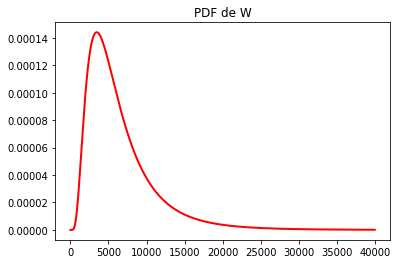

In [28]:
#Podemos ver la PDF
x=np.linspace(0,40000,100000)

plt.plot(x, W.pdf(x), linewidth=2, color='r')
plt.title('PDF de W');

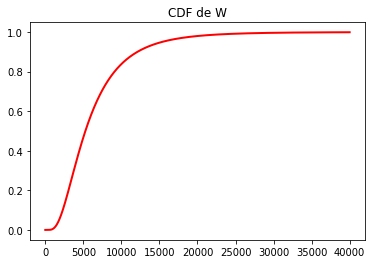

In [29]:
#Nos interesa la CDF:

plt.plot(x, W.cdf(x), linewidth=2, color='r')
plt.title('CDF de W');

#### 1.5.1 ¿Cuál es la probabilidad de que un empleado gane menos de 2.000 USD en este caso?

In [30]:
#Utilizamos la CDF para x = 2000
prob = W.cdf(2000)

print(f' la probabilidad de que un empleado gane menos de 2.000 USD en este caso es de {prob[0]}')

 la probabilidad de que un empleado gane menos de 2.000 USD en este caso es de 0.06788591151234148


#### 1.5.2  ¿Y de que gane más de 9.000 USD?


In [31]:
#Utilizamos la SF para x = 9000
prob = W.sf(9000)

print(f' la probabilidad de que un empleado gane más de 9.000 USD en este caso es de {prob[0]}')

 la probabilidad de que un empleado gane más de 9.000 USD en este caso es de 0.2046350601728138


### 1.6 Compare lo obtenido en la parte 4 y 5.

A continuación se compara la distribución teórica de la parte 1.5 con la muestra (parte 1.4)

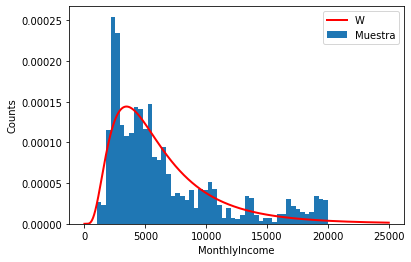

In [32]:
s = df[['MonthlyIncome']].to_numpy()
x=np.linspace(0,25000,100000)

count, bins, ignored = plt.hist(s, 50, density=True, align='mid')
plt.plot(x, W.pdf(x), linewidth=2, color='r')
plt.axis('tight')
plt.legend(('W','Muestra'))
plt.ylabel('Counts')
plt.xlabel('MonthlyIncome')
plt.show()

El ajuste de la curva teórica deja bastante que desear, sobre todo para valores de sueldo bajos. De igual manera, el comportamiento lognormal es relativamente notorio.

#### 1.6.1 ¿Se parecen estas probabilidades?

Al comparar las probabilidades, se tiene lo siguiente:

Sueldo menor a 2000 USD: 


*   Parte 4: 0.022448979591836733
*   Parte 5: 0.06788591151234148
*   Diferencia: 0.04543693192050475

Dado que las probabilidades para este valor son relativamente pequeñas, la sensibilidad aumenta y por lo tanto pequeñas diferencias a nivel general generan discrepancias grandes entre los valores si se les compara consigo mismo.


Sueldo mayor a 9000 USD: 


*   Parte 4: 0.22653061224489796
*   Parte 5: 0.2046350601728138
*   Diferencia: 0.021895552072084157

Aquí sí se ajusta bien el valor de la probabilidad, la diferencia es cercana al 10% de los valores. Aún así, no es suficientemente cercano para inferir que se tratan de la misma distribución.




#### 1.6.2 Utilice un gráfico qqplot para comparar la distribución de la variable MonthlyIncome contra una distribución lognormal.

NOTA: El qqplot en python se puede hacer creando una distribución teórica y comparar sus cuantiles con los de la muestra, y es lo que se hace en esta ocasión.

NOTA 2 : La línea QQ se desajustaba demasiado del gráfico qqPlot y por lo tanto no fue incluida.

In [33]:
#Se generan muestras teoricas


X = lognorm(s = [1],scale = np.exp(0))
Z = norm

#Se crean los cuantiles abarcando todos los datos

total_datos = len(s)

Z_100 = []
for i in np.arange(0,1,1/total_datos):
    Z_100.append(Z.ppf(i))

X_100 = []
for i in np.arange(0,1, 1/total_datos):
    X_100.append(X.ppf(i))

S_100 = []
for i in np.arange(0,1, 1/total_datos):
    S_100.append(np.quantile(s, i))

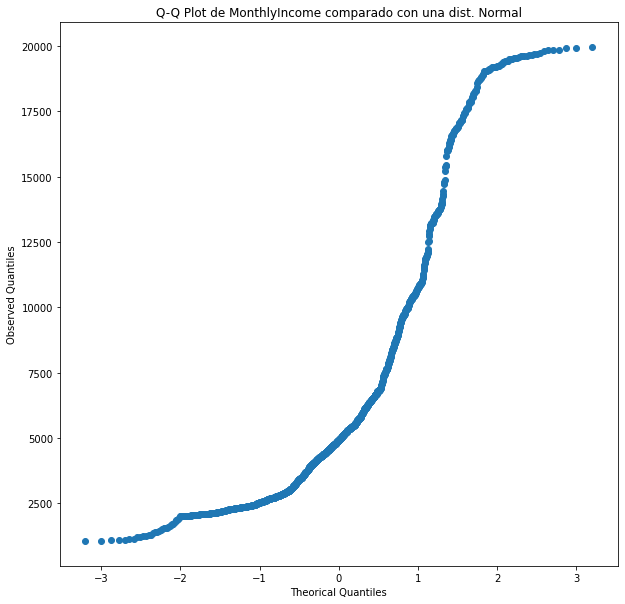

In [34]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.scatter(Z_100, S_100)

ax.set_title('Q-Q Plot de MonthlyIncome comparado con una dist. Normal')
ax.set_xlabel('Theorical Quantiles')
ax.set_ylabel('Observed Quantiles')

plt.show()

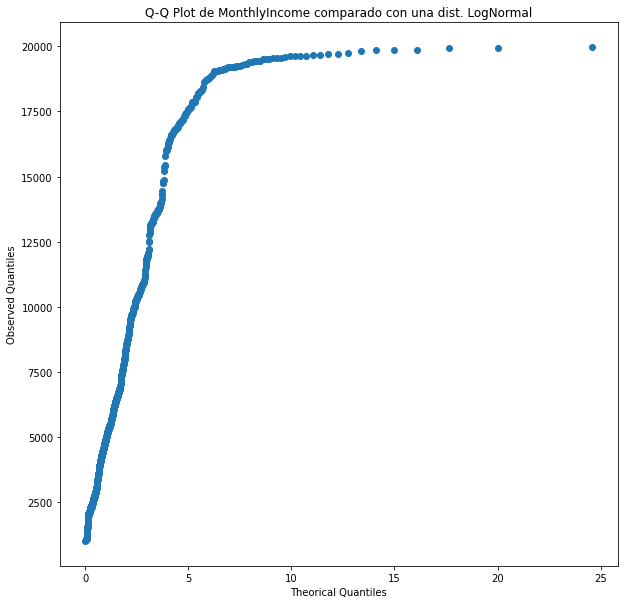

In [35]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
ax.scatter(X_100, S_100)

ax.set_title('Q-Q Plot de MonthlyIncome comparado con una dist. LogNormal')
ax.set_xlabel('Theorical Quantiles')
ax.set_ylabel('Observed Quantiles')

plt.show()

Tal como se menciona anteriormente, no se usó la línea QQ debido a que se desajusta demasiado del  gráfico. Aclarado lo anterior, es posible notar que los resultados de ajuste son pésimos, tanto al comparar los datos con una distribución normal como con una lognormal. Ninguno muestra tendencias lineales consistentes, por lo que contrario a lo que se creía antes de esta prueba, se puede afirmar que, al menos para este set de datos, el sueldo no distribuye logNormal (y tampoco normal).

##2. P2



### 2.1  Objetivo de estudio

El objetivo de estudio de este trabajo se limitará al análisis de las siguientes variables:

*   **Attrition** (variable objetivo)
*   MonthlyIncome
*   TotalWorkingYears
*   OverTime

Estas variables se enfocan fuertemenete en la dimensión de **desempeño**, pero inevitablemente es necesario evaluar cualitativamente las dimensiones de ambiente organizacional y socio demográfica también. Se intentará segmentar a los desertores según esta combinación de características. Las variables elegidas siguen la misma lógica de los resultados de las secciones 0.1.1 y 0.1.2 de este trabajo, ordenadas según el índice de Gini (ver p.19 del [artículo](https://documentation.sas.com/api/docsets/emgsj/15.1/content/emgsj.pdf?locale=en)) y las correlaciones. 




### 2.2 Tests de hipótesis



#### 2.2.1 Primer test

Lo primero que podría llamar la atención es la alta deserción al primer año de experiencia laboral, los cuales podrían tener razones distintas de renuncia con el resto de desertores, y entre ellas, el salario. En este test se dividirá a quienes renunciaron el primer año y hará un test de diferencia de medias con los sueldos de quienes renuncian al primer año o antes con respecto a quienes renunciaron posteriormente. A priori se sabe que estos valores debiesen ser diferentes, por temas de que a mayor experiencia hay mayor remuneración en general.


$$ H_0 : \bar{X} _{1} = \bar{X} _{2}  $$
$$ H_1 : \bar{X} _{1} < \bar{X} _{2}  $$


Con $\bar{X} _{1}$ el salario mensual promedio de quienes renunciaron con un año de experiencia o menos, mientras que $\bar{X} _{2}$ es el salario promedio mensual para quien renunció después de su primer año de experiencia.

In [36]:
## Dividimos en dos grupos

desertores_1_anio = df[(df['TotalWorkingYears'] <= 1) & (df['Attrition'] == 'Yes')]
resto_desertores = df[(df['TotalWorkingYears'] > 1) & (df['Attrition'] == 'Yes')]

## Extraemos parámetros necesarios

salario_x1 = desertores_1_anio['MonthlyIncome']
salario_x2 = resto_desertores['MonthlyIncome']

mean_x1 = salario_x1.mean()
mean_x2 = salario_x2.mean()

n_x1 = salario_x1.shape[0]
n_x2 = salario_x2.shape[0]

std_x1 = salario_x1.std()
std_x2 = salario_x1.std()

## Error estandar

S_2 = ((n_x1-1)*std_x1*std_x1 + (n_x2-1)*std_x2*std_x2)/(n_x1+n_x2-2)
SE = np.sqrt(S_2*((1/n_x1) + (1/n_x2)))

## Estadistico t
t=abs(mean_x1-mean_x2)/SE



In [37]:
n_x1 + n_x2 -2

235

Se asume el valor anterior como un número grande de ejemplos, por lo que se puede contrastar el estadístico con una distribución $N(0,1)$. Se utiliza un valor de significancia $\alpha = 0.01$

In [38]:
alpha = 0.01

valor_critico = norm.ppf(1-alpha) # test cola a la derecha
p_valor = 1-norm.cdf(t)

In [39]:
print(f'Valor del estadistico t: {t}, \nValor crítico para la zona de rechazo: {valor_critico} < t, \np-valor: {p_valor}')

Valor del estadistico t: 33.85114953951193, 
Valor crítico para la zona de rechazo: 2.3263478740408408 < t, 
p-valor: 0.0


Finalizado el test, dado que  $33.85 > 2.32$  ;   entonces se rechaza la hipótesis nula de que el sueldo promedio de quienes renuncian al primer año de experiencia laboral es igual al de quienes renuncian en años posteriores.

#### 2.2.2 Segundo test

Se puede ver además que la variable 'OverTime' pareciera estar equidistribuida entre quienes renuncian (i.e. el 50% de quienes renuncian hacía horas extras, mientras que el otro no). Se hará un test de diferencia de proporciones para evaluar esta hipótesis.

$$ H_0: p_{overtime} = p_{no\:overtime} $$
$$ H_1: p_{overtime} \neq p_{no\:overtime} $$

con $p_{overtime}$ la probabilidad que un renunciante sea del grupo de quienes hacían horas extra, y $p_{no \:overtime}$ la de quienes no hacían horas extra.


In [40]:
# Definimos las proporciones

renunciantes_horas_extra = df[(df['Attrition'] == 'Yes') & (df['OverTime'] == 'Yes') ]
renunciantes_no_horas_extra = df[(df['Attrition'] == 'Yes') & (df['OverTime'] == 'No') ]


n_overtime = renunciantes_horas_extra.shape[0]
n_no_overtime =  renunciantes_no_horas_extra.shape[0]

p_overtime = renunciantes_horas_extra.shape[0]/(renunciantes_horas_extra.shape[0] + renunciantes_no_horas_extra.shape[0])
p_no_overtime = renunciantes_no_horas_extra.shape[0]/(renunciantes_horas_extra.shape[0] + renunciantes_no_horas_extra.shape[0])

## P gorro:

p_gorro = (p_overtime*n_overtime+ p_no_overtime * n_no_overtime)/(n_overtime + n_no_overtime)

## Error estandar:

SE_p = np.sqrt(p_gorro*(1-p_gorro)*((1/n_overtime) + (1/n_no_overtime)))

## Estadistico z:

Z = (p_overtime-p_no_overtime)/(SE_p)


print(f'P gorro: {p_gorro} \nSE: {SE_p} \nEstadistico Z: {Z}')

P gorro: 0.5025725934234186 
SE: 0.06512387374721497 
Estadistico Z: 1.101438745556421


Asumimos que el estadistico z es comparable con $N(0,1)$. Para $\alpha = 0.05$ se tiene lo siguiente:

In [41]:
alpha = 0.05

valor_critico = norm.ppf(1-alpha) 
print(f'valor critico: z > {valor_critico}')


valor critico: z > 1.6448536269514722


Dado que $Z \ngtr Z_{1-alpha}$, no se puede rechazar la hipótesis nula

#### Tercer test

Los tests restantes analizarán la variable de sueldo para quienes tienen más de un año de experiencia. Lo anterior es basado en que el primer test sugiere que estos dos grupos son diferentes (i.e. quienes tienen un año o menos de experiencia con quienes tienen más). De esta forma, este test comparará las medias de sueldo de quienes renunciaron con la de quienes no renunciaron, y que además tengan más de un año de experiencia.


$$ H_0 : \bar{M} _{r} = \bar{M} _{nr}  $$
$$ H_1 : \bar{M} _{r} < \bar{M} _{nr}  $$


Con $\bar{M} _{r}$ el ingreso mensual promedio de quienes renunciaron, y $\bar{M} _{nr}$ el de quienes no renunciaron. 

In [42]:
## Dividimos en dos grupos

renuncia = df[(df['TotalWorkingYears'] > 1) & (df['Attrition'] == 'Yes')]
no_renuncia = df[(df['TotalWorkingYears'] > 1) & (df['Attrition'] == 'No')]

## Extraemos parámetros necesarios

salario_r = renuncia['MonthlyIncome']
salario_nr = no_renuncia['MonthlyIncome']

mean_r = salario_r.mean()
mean_nr = salario_nr.mean()

n_r = salario_r.shape[0]
n_nr = salario_nr.shape[0]

std_r = salario_r.std()
std_nr = salario_r.std()

## Error estandar

S_2 = ((n_r-1)*std_r*std_r + (n_nr-1)*std_nr*std_nr)/(n_r+n_nr-2)
SE = np.sqrt(S_2*((1/n_r) + (1/n_nr)))

## Estadistico t
t=abs(mean_r-mean_nr)/SE

In [43]:
n_r + n_nr -2

1376

El valor anterior es suficientemente grande para comparar el estadistico t con $N(0,1)$. Para $\alpha = 0.1$ se tiene:

In [44]:
alpha = 0.01

valor_critico = norm.ppf(1-alpha) # test cola a la derecha
p_valor = 1-norm.cdf(t)
print(f'Valor del estadistico t: {t}, \nValor crítico para la zona de rechazo: {valor_critico} < t, \np-valor: {p_valor}')

Valor del estadistico t: 5.45622777343005, 
Valor crítico para la zona de rechazo: 2.3263478740408408 < t, 
p-valor: 2.431779899669806e-08


Dado que se cumple la condición de rechazo para el valor de $\alpha$ antes dado, se rechaza la hipótesis nula de que el sueldo promedio de quienes renunciaron es igual que el de quienes no renunciaron.

#### Cuarto test

Se hará un test de diferencia de varianzas para la variable sueldo, comparando las varianzas del sueldo para quienes renunciaron con la de quienes no renunciaron, con una experiencia laboral mayor a un año.

$$H_0 : \frac{\sigma^2_r}{\sigma^2_{nr}} = 1$$
$$H_0 : \sim$$

Con $\sigma^2_r$ la varianza del sueldo del grupo que renunció y $\sigma^2_{nr}$ la varianza del sueldo de quien **no** renunció

In [45]:
## calculo de varianzas muestrales
var_r = salario_x1.var()
var_nr = salario_x2.var()

# Estadistico F

F = var_r/var_nr

In [46]:
F

0.024931926959282636

Se compara el estadístico F con $F_{nr -1, nnr -1}$, con $nr$ el numero de ejemplos de empleados que renunciaron y $nnr$ el de empleados que no renunciaron.






In [47]:
alpha = 0.01

df1 = n_r - 1
df2 = n_nr -1

F_rechazo = f.ppf(1-alpha, df1, df2)

p_valor = 1-f.cdf(F,  df1, df2)

print(f'Valor del estadistico F: {F}, \nValor F critico: F>{F_rechazo}, \nP-valor: {p_valor}')


Valor del estadistico F: 0.024931926959282636, 
Valor F critico: F>1.2793689928132528, 
P-valor: 1.0


Consecuente a los resultados obtenidos en el test ($F \ngtr F_{nr-1,nnr-1} $), no se rechaza la hipótesis nula de que las varianzas de ambos grupos son iguales.

### 2.3 Analice sus resultados y concluya


A lo largo de esta investigación se pueden rescatar diversos resultados, algunos concluyentes y otros en los cuales se debe seguir investigando. En primer lugar, el hecho que existan subgrupos característicos del grupo que renunció, sugiere que hay al menos dos razones distintas por las cuales los empleados renunican, e intuitivamente es natural pensar que las razones no son solo dos sino que son múltiples. El ordenar las variables por correlacción o indice de Gini no dice nada directamente sin un análisis cualitativo detrás, y debido a esto es que se utiizó como una guía solamente que permitiese intuír por qué valores habría más información potencialmente relevante.

Con respecto a los tests de hipótesis hechos, estos reafirman ciertas sospechas tomadas al analizar los histogramas, y ponen en duda otras que parecían ser ciertas bajo algunas visualizaciones de información. Lo anterior puede verse con dos ejemplos claros y opuestos, en primer lugar, con el test n°1, la división en subgrupos de los trabajadores que renunciaron con solo un año de experiencia del resto y su sueldo promedio, el cual lógicamente debiese ser inferior al del resto de la muestra; el resultado del test fue favorable al indicar que se rechazaba la hipótesis nula. Por otro lado, con el test n°4, no se rechazó la hipótesis nula de que las varianzas de sueldo son iguales para los que renuncian tanto como para los que no, y por lo tanto no hay información concluyente que permita afirmar que estos valores son distintos.

A nivel general, se puede ver que el perfil mayoritario de quienes renunciaron corresponde a gente joven, con escasa experiencia laboral, y con sueldos bajos. Las conjeturas que se desprenden de este estudio sugieren además segmentar en distintos grupos (por ejemplo, según experiencia laboral) y evaluar qué sucede en cada uno de ellos, tal como se podría hacer con un clustering. Finalmente, como conclusión final, es necesario aclarar que se requieren más estudios y uso de distintas otras técnicas para poder sacar conclusiones de por qué renuncian los empleados realmente.